# 3rd practice: Neural Networks
* **Course**: Artificial Intelligence
* **University**: Universitat Rovira i Virgili

In this practice students will explore the following fundamentals of machine learning:
* Data analysis
* Preprocessing
* Basic desgin of Multi-Layer Perceptrons (MLP)
* Training of neural networks
* Results analysis
* Decision making / Critical thinking

While reading this notebook, please note the following information:
* Each section (and subsection) has a title and a brief description of its contents.
* If a section (or subsection) title starts with `Student`, the student has work to do inside it, adding code and/or text.
* If the title of a section begins with `Teacher`, all its content (including subsections) is part of the work statement. Subsequently, it **MUST NOT** be modified.
* Sections must be executed in order.
* **<font color='lightgreen'>Please enter your full name in the next cell in this section and run it BEFORE going any further.</font>**

## External resources
Please, read the following tutorials to get an introduction to Google Colab and the Pandas library:
* https://colab.research.google.com/notebooks/basic_features_overview.ipynb
* https://colab.research.google.com/notebooks/mlcc/intro_to_pandas.ipynb

## Deliverable
It is an **individual** practice. The student only needs to deliver **this notebook** including the answers. The file must have as name `P3_[Name]_[Surname/s].ipynb`, replacing `[Name]` and `[Surname/s]` with those from the student.

## Evaluation
To be accepted, all practices delivered must contain at least **one solution with a preprocessing step** and **one solution with a modified neural network**.
A third solution with a second preprocessing step will be valued.

<font color='orange'>**Similar or identical practices will get a grade of 0.**</font>

In [3]:
STUDENT_NAME = "GERMÁN PUERTO RODRÍGUEZ" # @param {type:"string"}

# Teacher: Initialization
Defines the **Imports** and **Device** for the practice. More details in each subsection.

## Imports
The following code cell determines the available packages/libraries.

**You CANNOT add any other import, neither here nor anywhere else in the code.**

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Device
Checks if there is a GPU for training the neural networks. If not, the CPU will be used. It is recommended to first test if the preprocessing and model definition are correct in a CPU-based environment and then switch to the GPU-based environment for training.

In [5]:
if torch.cuda.is_available():
  DEVICE = "cuda"
  print("There is GPU available. Printing GPU information:")
  !nvidia-smi
else:
  DEVICE = "cpu"
  print("There is no GPU available, using CPU.")

There is no GPU available, using CPU.


# Teacher: Base code
<a name="base_code"></a>

Code available for use in the `Student` sections.

## Data loading
This loads the `CarsData.csv` file (available in Moodle) as a Pandas dataframe. **The file must first be loaded into the environment folder** 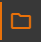. If you use a web browser *other* than Google Chrome, the loading may fail (e.g., the loading circle is red and never ends).

This dataset will be used for the **Manufacturer classification task**, where the machine learning model aims to predict/output the Manufacturer of a car using the rest of features as inputs.

The dataset was extracted from [this website](https://www.kaggle.com/datasets/meruvulikith/90000-cars-data-from-1970-to-2024/data). The dataframe to be used in practice is a 25% subsample of the full dataset, different from that of other students.

In [6]:
LABEL_COL_NAME = "Manufacturer" # Global constant

def data_loading(file_name):
  original_df = pd.read_csv(file_name)
  original_df = original_df.drop(columns=["model"]) # Model column is not available
  original_df

  # Infer column types
  infer_type = lambda x: x if pd.api.types.is_numeric_dtype(x) else pd.Categorical(x)
  original_df = original_df.apply(infer_type, axis=0)

  # Select subset
  frac=0.25
  random_seed = hash(STUDENT_NAME) % (2**32-1) # Seed must be between 0 and 2**32 - 1
  student_df = original_df.sample(frac=frac, random_state=random_seed).reset_index()
  student_df = student_df.drop(columns=["index"])

  return student_df

## Analysis
Functions that facilitate the data distribution analysis for the [Student: Exploratory data analysis](#data_analysis) section.

In [7]:
def feature_histogram(df, column_name):
    column_data = df[column_name]

    if pd.api.types.is_numeric_dtype(column_data):
        plt.hist(column_data, bins=10)
    else:
        value_counts = column_data.value_counts()
        value_counts.plot(kind='bar')

    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(column_name))
    plt.show()


def feature_stats(df, column_name, verbose=True):
  stats = {}
  column_data = df[column_name]

  # Numerical
  if pd.api.types.is_numeric_dtype(column_data):
    stats["Min"] = column_data.min()
    stats["Max"] = column_data.max()
    stats["Mean"] = column_data.mean()
    stats["Std"] = column_data.std()

  # Categorical
  elif pd.api.types.is_categorical_dtype(column_data):
    stats["Unique"] = column_data.value_counts()

  if verbose and len(stats) > 0:
    stats_str = ""
    for name, value in stats.items():
      stats_str += f" {name}={value} |"
    print(f"Stats of {column_name}:{stats_str}")

  return stats


def features_relationship(df, column_name_1, column_name_2):
    data1 = df[column_name_1]
    data2 = df[column_name_2]

    # Both columns are numerical
    if pd.api.types.is_numeric_dtype(data1) and pd.api.types.is_numeric_dtype(data2):
        plt.scatter(data1, data2)
        plt.xlabel(column_name_1)
        plt.ylabel(column_name_2)
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # Both columns are categorical
    elif pd.api.types.is_categorical_dtype(data1) and pd.api.types.is_categorical_dtype(data2):
        cross_table = pd.crosstab(data1, data2)
        cross_table.plot(kind='bar', stacked=True)
        plt.xlabel(column_name_1)
        plt.ylabel('Frequency')
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # A column is numerical and the other categorical
    else:
        # Check which is which
        if pd.api.types.is_categorical_dtype(data1):
            categorical_column = column_name_1
            numerical_column = column_name_2
        else:
            categorical_column = column_name_2
            numerical_column = column_name_1

        # Get data
        categorical_data = df[categorical_column]
        numerical_data = df[numerical_column]

        # Convert categorical data to numeric representation
        categorical_codes = categorical_data.astype('category').cat.codes

        # Plot
        plt.scatter(numerical_data, categorical_codes)
        plt.xlabel(numerical_column)
        plt.ylabel(categorical_column)
        plt.title('Relationship between {} and {}'.format(numerical_column, categorical_column))
        plt.yticks(ticks=categorical_codes.unique(), labels=categorical_data.unique()) # Set yticks labels as category names
        plt.show()

## PyTorch dataset
Function that transforms the preprocessed dataframe into the training and test datasets using the PyTorch TensorDataset class. To be used in the [Experiments](#experiments) section.

In [8]:
def df_to_dataset(preprocessed_df, label_col_name=LABEL_COL_NAME):
  if not label_col_name in preprocessed_df.columns:
    raise Exception(f"Dataframe MUST contain the label column [{label_col_name}], preferably in the last column.")

  # Obtain inputs and labels
  columns_to_discard = [col_name for col_name in preprocessed_df.columns if col_name == label_col_name]
  x = preprocessed_df.drop(columns=columns_to_discard)
  y = preprocessed_df[label_col_name]

  # Encode labels (string to identifier integer)
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)

  # Convert data to PyTorch tensors
  x_tensor = torch.tensor(x.values, dtype=torch.float)
  y_tensor = torch.tensor(y, dtype=torch.long)

  # Train-test split: 80% train, 20% test
  x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42, shuffle=True)

  # Create PyTorch datasets
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  # Get additional information for the model
  input_size = x_train_tensor.shape[1]
  num_classes = len(label_encoder.classes_)

  return train_dataset, test_dataset, input_size, num_classes, label_encoder

## Model
Basic function for the model creation and its movement to the corresponding DEVICE (GPU or CPU). To be used in the [Experiments](#experiments) section.

In [9]:
def create_model(model_class, input_size, num_classes, verbose=True):
  model = model_class(input_size, num_classes)
  model.to(DEVICE)

  if verbose:
    num_parameters = 0
    for layer in model.parameters():
      num_parameters += layer.nelement() * layer.element_size()
    print(f"The model has {num_parameters} parameters")

  return model

## Training
Function that trains a **model** with a **dataset**, for a **number of epochs** and using a specific **learning rate (lr)**. To be used in the [Experiments](#experiments) section.

In [10]:
def train(model, dataset, num_epochs, lr):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create PyTorch dataloader
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Set up loss evolution plot
    losses = []
    plt.ion()
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Evolution')
    line, = ax.plot([], [])

    # Training loop
    for epoch in range(num_epochs):
        # Set model to train mode
        model.train()

        epoch_loss = 0.0
        num_batches = 0

        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update epoch loss
            epoch_loss += loss.item()
            num_batches += 1

        # Update lists for loss plotting
        mean_epoch_loss = epoch_loss / num_batches
        losses.append(mean_epoch_loss)

        # Update plot
        line.set_ydata(losses)
        line.set_xdata(range(1, len(losses)+1))
        ax.relim()
        ax.autoscale_view()
        display.clear_output(wait=True)
        display.display(plt.gcf())

        # Print specific epoch info
        print(f'Epoch [{epoch+1}/{num_epochs}] | Mean epoch loss: {mean_epoch_loss:.4f}')

    # Turn off interactive mode and show plot
    plt.ioff()
    plt.close()

    return losses

## Evaluation
Functions for the result analysis of the [Experiments](#experiments) section. In particular, for the analysis of [classification accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=es-419) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).


In [11]:
def evaluate(model, dataset):
  # Create dataloader
  eval_loader = DataLoader(dataset, batch_size=256, shuffle=False)

  model.eval()  # Set model to evaluation mode
  with torch.no_grad():
      correct = 0
      total = 0
      all_targets = np.empty(len(dataset), dtype=int)
      all_predicted = np.empty_like(all_targets)
      for inputs, targets in eval_loader:
          # Move data to GPU
          inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

          # Forward pass
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          # Store targets and predicted labels
          all_targets[total:total+targets.size(0)] = targets.cpu().numpy()
          all_predicted[total:total+targets.size(0)] = predicted.cpu().numpy()

          # Update total and correct predictions
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

      accuracy = correct / total

  return accuracy, all_targets, all_predicted


def plot_confusion_matrix(all_targets, all_predicted, label_encoder):
  # Calculate confusion matrix
  cm = confusion_matrix(all_targets, all_predicted)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

# Student: Exploratory data analysis
<a name="data_analysis"></a>

In this section, the student will have to perform the following tasks:
* Load the dataset.
* Analyze each feature's data distribution using plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per feature) about them.
* Analyze relevant relationships between pairs of features' data distributions with plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per relationship) about them. Focus only on the important pairs to avoid overwhelming combinations.

In [12]:
df = data_loading("/content/drive/MyDrive/CarsData.csv")

Once we have loaded the dataset, we are going to analyze each attribute and the pairs of important attributes, so that later in the preprocessing we can design a more specific system.

In [13]:
df

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,2018,25620,Semi-Auto,13958,Hybrid,135,166.0,1.4,volkswagen
1,2016,17979,Automatic,47448,Hybrid,0,134.5,2.0,merc
2,2017,12296,Semi-Auto,29603,Petrol,125,51.4,1.2,skoda
3,2011,8449,Manual,63978,Petrol,555,26.6,2.8,vauxhall
4,2018,11999,Semi-Auto,17682,Petrol,145,52.3,1.2,vauxhall
...,...,...,...,...,...,...,...,...,...
24423,2019,31440,Semi-Auto,4675,Petrol,145,40.9,2.0,BMW
24424,2017,14899,Manual,42560,Diesel,30,62.8,2.0,BMW
24425,2016,7995,Semi-Auto,17762,Petrol,20,62.8,1.0,skoda
24426,2017,52990,Automatic,27195,Diesel,145,39.2,4.0,Audi


Attributes Included:

    Year: The manufacturing year of the car.
    Price: The price of the car.
    Transmission: The type of transmission used in the car.
    Mileage: The mileage of the car.
    FuelType: The type of fuel used by the car.
    Tax: The tax rate applicable to the car.
    MPG: The miles per gallon efficiency of the car.
    EngineSize: The size of the car's engine.
    Manufacturer: The manufacturer of the car and the ATTRIBUTE TO PREDICT



### Year

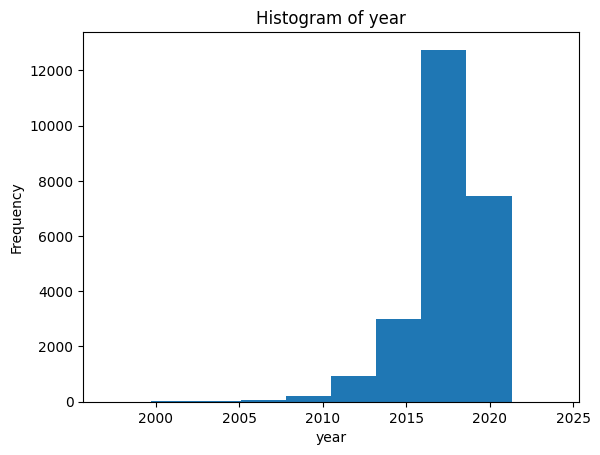

In [14]:
feature_histogram(df,"year")

In [15]:
feature_stats(df, "year")

Stats of year: Min=1997 | Max=2024 | Mean=2017.052030456853 | Std=2.104982706794457 |


{'Min': 1997, 'Max': 2024, 'Mean': 2017.052030456853, 'Std': 2.104982706794457}

For the attribute of the year of manufacture we see in the statistics that the majority are concentrated in the 2010s. I think that to predict the factory, it will not be very useful for two reasons:
- Physical/economic characteristics are more important.
- The data is very similar for all types of cars.

### Price

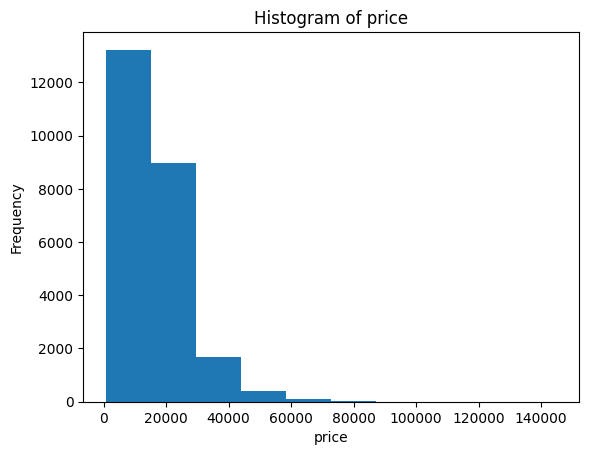

In [16]:
feature_histogram(df,"price")

In [17]:
feature_stats(df, "price")

Stats of price: Min=650 | Max=145000 | Mean=16771.239274602915 | Std=9905.932135566649 |


{'Min': 650,
 'Max': 145000,
 'Mean': 16771.239274602915,
 'Std': 9905.932135566649}

For the price attribute, we see that the statistical values are reasonable, and the average is around 16k. The price will be useful for prediction since there is usually a quality-price ratio based on the brand or physical characteristics.

You will have to be careful with using the minimum and maximum since they are values very far from the average.

### Transmission

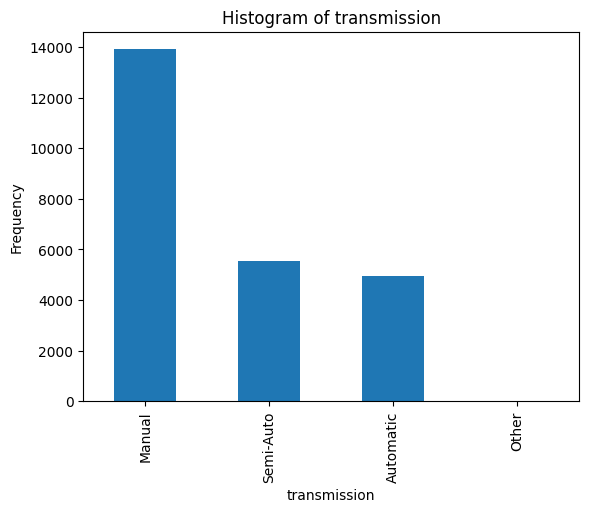

In [18]:
feature_histogram(df,"transmission")

In [19]:
feature_stats(df, "transmission")

Stats of transmission: Unique=transmission
Manual       13913
Semi-Auto     5555
Automatic     4958
Other            2
Name: count, dtype: int64 |


{'Unique': transmission
 Manual       13913
 Semi-Auto     5555
 Automatic     4958
 Other            2
 Name: count, dtype: int64}

For the transmission attribute, we see that we only have 4 types, manual, semi-automatic, automatic and others. Although it is a small classification, it will be useful to us since there may be a direct relationship between:
- Transmission type and price
- Transmission type and manufacturer

We see that the ones we have the most are manual.

### Mileage

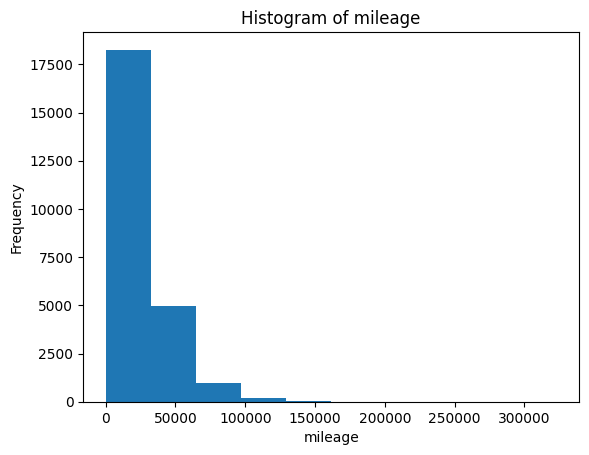

In [20]:
feature_histogram(df,"mileage")

In [21]:
feature_stats(df, "mileage")

Stats of mileage: Min=1 | Max=323000 | Mean=23250.81783199607 | Std=21067.652559872055 |


{'Min': 1, 'Max': 323000, 'Mean': 23250.81783199607, 'Std': 21067.652559872055}

For the mileage attribute, something similar happens to the price. Using the mean and deviation will be useful to us, but if we want to use the minimum and maximum, since they are so far away we will have to complement them in a formula or algorithm. It can also be useful to combine the mileage with the type of fuel since it is usually a proportional relationship.

### FuelType

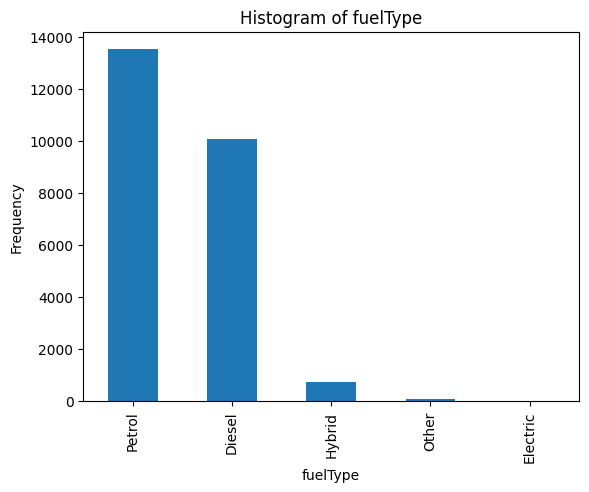

In [22]:
feature_histogram(df,"fuelType")

In [23]:
feature_stats(df, "fuelType")

Stats of fuelType: Unique=fuelType
Petrol      13528
Diesel      10089
Hybrid        735
Other          71
Electric        5
Name: count, dtype: int64 |


{'Unique': fuelType
 Petrol      13528
 Diesel      10089
 Hybrid        735
 Other          71
 Electric        5
 Name: count, dtype: int64}

For the fuel attribute, we have 5 types Petrol, Diesel, Hybrid, Other, Electric. It is a similar case to the type of transmission, it is a small but useful classification since there may be a relationship between fuel and mileage as we have said before. Petrol and Diesel types are the most popular.

### Tax

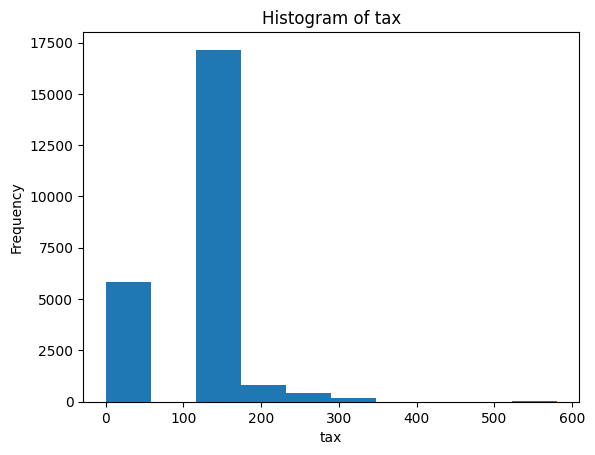

In [24]:
feature_histogram(df,"tax")

In [25]:
feature_stats(df, "tax")

Stats of tax: Min=0 | Max=580 | Mean=119.99713443589324 | Std=64.02056429280135 |


{'Min': 0, 'Max': 580, 'Mean': 119.99713443589324, 'Std': 64.02056429280135}

For the rate attribute, we will have to do tests to see what attribute it could be related to since if we do not know about cars, we do not know the rates if they are calculated based on some characteristic. The rates are in a more limited range not like the price, so if we want to operate with the rates it will be easier.

### MPG

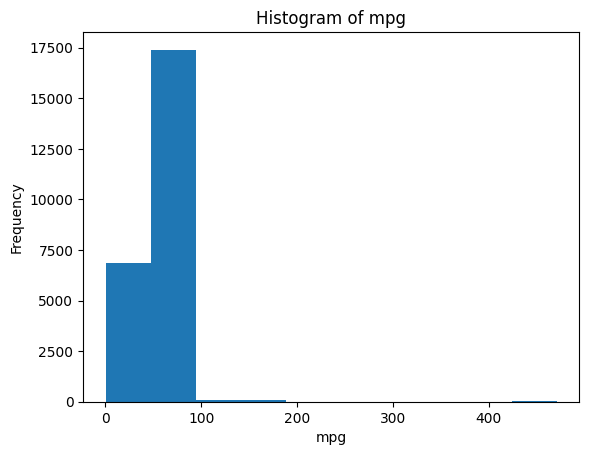

In [26]:
feature_histogram(df,"mpg")

In [27]:
feature_stats(df, "mpg")

Stats of mpg: Min=0.3 | Max=470.8 | Mean=55.22307597838546 | Std=17.230176741582117 |


{'Min': 0.3,
 'Max': 470.8,
 'Mean': 55.22307597838546,
 'Std': 17.230176741582117}

For the mpg attribute, the values are also quite limited, so the minimum and maximum will not be as critical to use in the calculations. The mpg does not vary much depending on the car, since obviously a normal car cannot vary too much, so perhaps we could weight this attribute so that it would have more notoriety.

### EngineSize

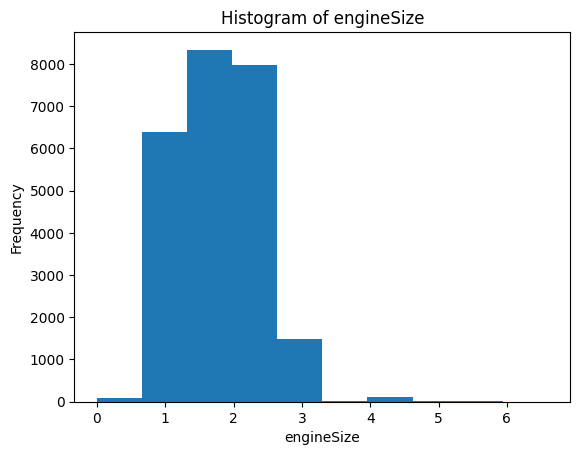

In [28]:
feature_histogram(df,"engineSize")

In [29]:
feature_stats(df, "engineSize")

Stats of engineSize: Min=0.0 | Max=6.6 | Mean=1.6692156541673489 | Std=0.5654635755051484 |


{'Min': 0.0, 'Max': 6.6, 'Mean': 1.6692156541673489, 'Std': 0.5654635755051484}

For the engineSize attribute, we have 1 to 6, and the size will probably be related to the mpg, so now in the relations section we will check it.

### Relevant relationships

As I mentioned in the last section, the size of the car and the mpg are probably relationally proportional and in effect, we see that in the graph cars between 2 and 3 in size have more mpg.

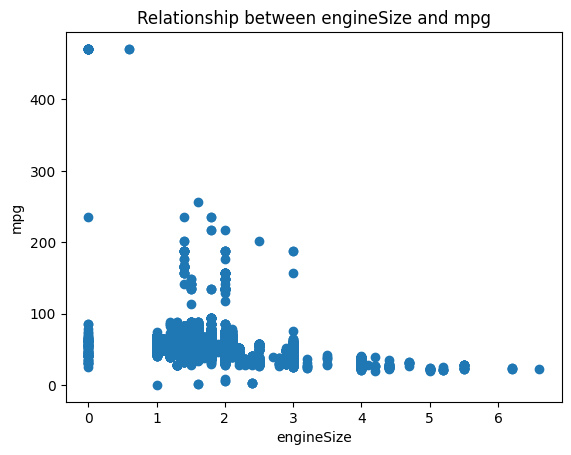

In [30]:
features_relationship(df, "engineSize", "mpg")

Another interesting relationship is that of rates and size, since the larger the size, the more expensive it is, which makes sense.

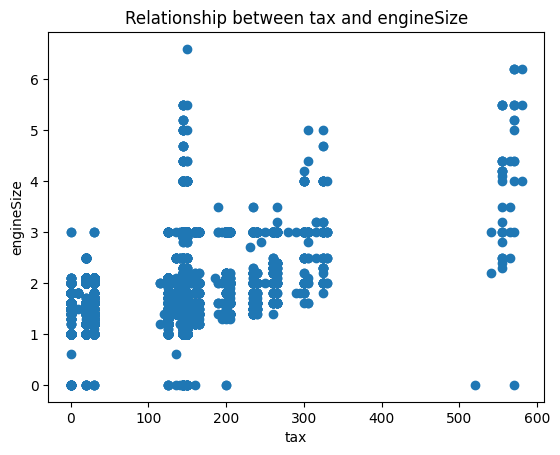

In [31]:
features_relationship(df, "tax", "engineSize")

Another interesting relationship is that of fuel and mileage, where diesel predominates. We will not trust this relationship too much since it could turn out this way due to the small amount of electric, others, etc.

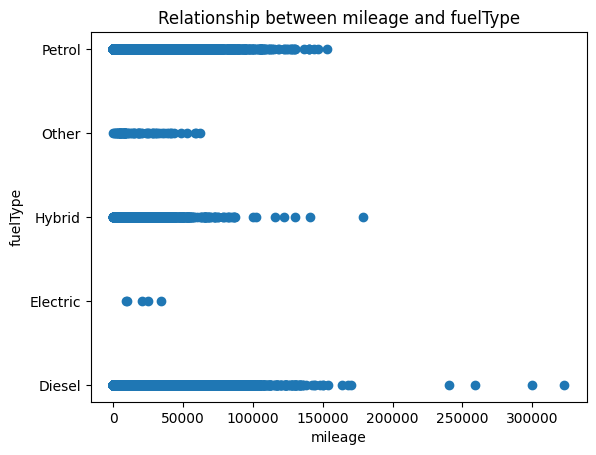

In [32]:
features_relationship(df, "fuelType", "mileage")

Despite considering the year of manufacture individually not relevant, the relationships with other attributes are very useful since you can see, for example, compared to the price, the price increase that has occurred over the last few years of car manufacturing. Perhaps there may be a relationship between the brand and not the year individually but the year weighted with another attribute.

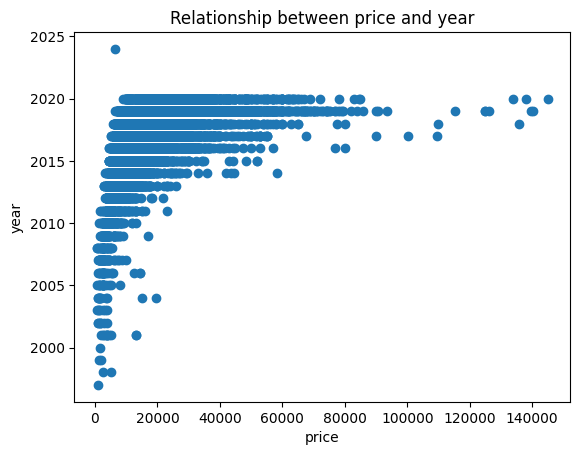

In [33]:
features_relationship(df, "price", "year")

# Teacher: Baseline solution
<a name="baseline"></a>
This defines the most basic (and unsuccessful) ready-to-use solution for the **Manufacturer classification task**. It includes the main components:
* Preprocessing
* Model
* Training
* Evaluation

Nonetheless, there are a lot of important things missing, as can be seen from the very poor results. Use this as inspiration for your [Solution 1A](#solution_1a), that **must** be better than this.

## Preprocessing

In [53]:
def preprocessing_0(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  columns_to_use = ["year", "price", "mileage", "tax", "mpg", "engineSize"] + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  column_transformer = ColumnTransformer([('onehot', OneHotEncoder(), categorical_cols)],
                                         remainder='passthrough')
  preprocessed_df = pd.DataFrame(column_transformer.fit_transform(preprocessed_df))
  # IMPORTANT: Student's can't use ColumnTransformer or similars, only Pandas functions

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_0(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

## Model

In [54]:
class Model_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_0, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, num_classes),
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_0, input_size, num_classes)

The model has 576 parameters


## Training

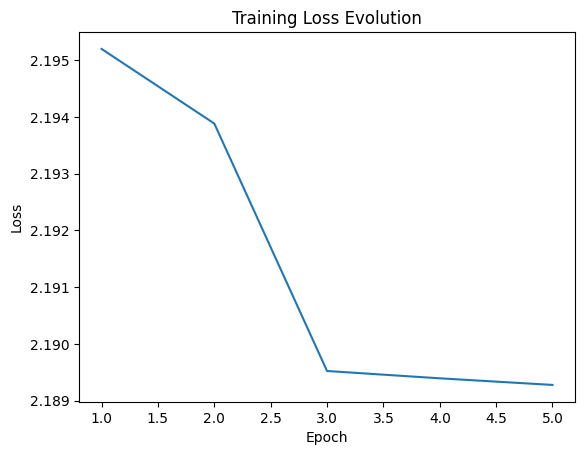

Epoch [5/5] | Mean epoch loss: 2.1893
CPU times: user 4.69 s, sys: 162 ms, total: 4.85 s
Wall time: 4.79 s


In [55]:
%%time
losses = train(model, train_dataset, num_epochs=5, lr=0.001)

## Evaluation

Train accuracy: 18.26%
Test accuracy: 17.58%


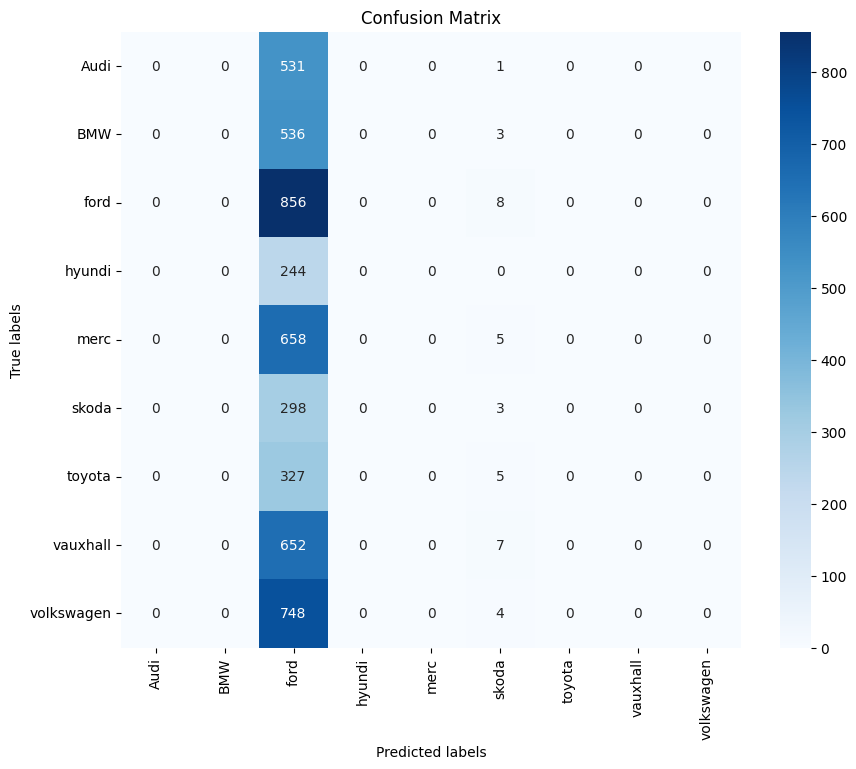

In [56]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

# Student: Experiments
<a name="experiments"></a>

In this section, the student will have to create two or three consequent solutions for the **Manufacturer classification task**. Each solution must contain the following components:
* **Idea**: What is the target/reasoning of the solution (e.g., I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model).
* **Preprocessing**: Prepare the desired features of your dataframe for the neural network. To this end, students can <font color='orange'>**only use Pandas' functions**</font>.
* **Model**: Definition of the Multi-Layer Perceptron model, **only** using [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers and
 [activations from this list](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
* **Training**: Perform the learning process trying to maximize the results.
* **Evaluation**: Measuring the performance of the trained model.
* **Results analysis**: Examination of the solution, focusing in:
  * Training
  * Accuracy
  * Confusion matrix
  * Training time

It can be seen that these are the same as for the baseline solution, but adding the **Idea** and **Results analysis** components. An extended analysis of the baseline results will also be requested.

None of the solutions has to be the best/ideal, but all of them must be better than the [baseline](#baseline). The idea is to present consequent solutions, being each one the coherent next step of the previous one (the previous step of [Solution 1A](#solution_1a) is the [baseline](#baseline)). This does not imply that each solution has to improve the results of the previous one, but to modify at least one of the components (i.e., preprocessing or model) in a significant and coherent way.

In particular, we aim for the first two solutions ([Solution 1A](#solution_1a) and [Solution 1B](#solution_1b)) to emphasize preprocessing. Specifically, both will utilize the same basic MLP model (better than that of the [baseline](#baseline)) but experiment with two distinct preprocessing approaches. An explicit comparison of these preprocessing methods and their respective outcomes is necessary. For [Solution 2](#solution_2), the preprocessing method from one of the earlier solutions will be employed. The goal of this final solution is to enhance results by improving/refining the MLP model.

## Analysis of baseline
Provide a comprehensive analysis of the [baseline solution](#baseline). Apart from the results (i.e., **training, accuracy, confusion matrix and runtime**), a review of the solution design (i.e., **preprocessing and model**) is also required. It is not necessary to explain or analysis the code, but the choices. For instace, which features are used and how.

### Preprocessing
The baseline preprocessing algorithm has a very basic objective. On the one hand, it takes the categorical attributes and converts them into integers using OneHotEncoder encoding; and on the other hand, he simply leaves the numeral attributes as is. This makes the model have crazy values, since it is very difficult without some type of operation to compare, for example, a year and a price.

### Model
The baseline MLP model algorithm also follows a basic methodology. It simply has 1 layer where we have 9 neurons (corresponding to the number of classes) and each neuron 14 inputs (corresponding to the number of classes with the relevant One Hot encodings). Then all it does is an activation function to normalize the probabilities, but since there are no more layers, the model does not influence the result.

### Result analysis

- Training: The first model trained in the shortest amount of time (4.85 seconds) compared to the other models you described (1 minute 25 seconds, 43.9 seconds). This is likely because the first model is simpler (i.e. it may have fewer layers or neurons) than the other models.

- Accuracy: The model has the lowest training accuracy (18.26%) and test accuracy (17.58%) compared to the other models. This suggests that the model may not have learned much from the training data. There are a couple of reasons for this:
  - Simple Model: The model may be too simple to capture the complexity of the data.
  - Data Issues: There may be problems with the data itself, such as noise, errors, or class imbalance.

- Confusion Matrix: It appears that the model is not very good at classifying any of the car brands correctly. This is reflected in the low overall accuracy.

- Training Time: The first model trained the fastest (4.85 seconds) as discussed earlier.

In conclusion, the first model did not perform well on this task. It achieved low accuracy and the confusion matrix shows it struggled to classify any of the car brands correctly. This could be due to the model being too simple or there may be issues with the training data.





## Solution 1A: First preprocessing
<a name="solution_1a"></a>

Subsequent of [Baseline](#baseline), it implements a basic MLP (better than the provided at the baseline) and a first option for the preprocessing step.

### Idea

The idea of preprocessing algorithm 1A is to implement an improvement over the baseline.
The main improvement that we can make is the one mentioned in the baseline analysis, is to find a way to compare numerical values without any type of quantitative relationship, for example a year of manufacture and the price. To do this, I will use the ranging function for all numerical columns.

### Preprocessing

In [38]:
def preprocessing_1A(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
  columns_to_use = numerical_cols + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  # One-hot enconding (OHE) of categorical columns
  for old_col in categorical_cols:
    # Get OHE of the column
    onehot_encoding_df = pd.get_dummies(preprocessed_df[old_col]) * 1 # Cast int

    # Append the OHE to the dataframe
    for new_col in onehot_encoding_df.columns:
      preprocessed_df[new_col] = onehot_encoding_df[new_col]

    # Delete the old categorical column
    del preprocessed_df[old_col]

# FUNCION DE NORMALIZACION
# MEJORAS EN FUNCION DEL ANALISIS DE ATRIBUTOS
  for col in numerical_cols:
    preprocessed_df[col] = [(i - preprocessed_df[col].min())/(preprocessed_df[col].max() - preprocessed_df[col].min()) for i in preprocessed_df[col]]

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

In [39]:
preprocessed_df = preprocessing_1A(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

In [40]:
# Atributos + id resultado
preprocessed_df

,year,price,mileage,tax,mpg,engineSize,Automatic,Manual,Other,Semi-Auto,Diesel,Electric,Hybrid,Petrol,Manufacturer
0,0.777778,0.172982,0.043211,0.232759,0.352179,0.212121,0,0,0,1,0,0,1,0,volkswagen
1,0.703704,0.120048,0.146895,0.000000,0.285228,0.303030,1,0,0,0,0,0,1,0,merc
2,0.740741,0.080679,0.091647,0.215517,0.108608,0.181818,0,0,0,1,0,0,0,1,skoda
3,0.518519,0.054028,0.198072,0.956897,0.055898,0.424242,0,1,0,0,0,0,0,1,vauxhall
4,0.777778,0.078621,0.054740,0.250000,0.110521,0.181818,0,0,0,1,0,0,0,1,vauxhall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24423,0.814815,0.213301,0.014471,0.250000,0.086291,0.303030,0,0,0,1,0,0,0,1,BMW
24424,0.740741,0.098711,0.131762,0.051724,0.132837,0.303030,0,1,0,0,1,0,0,0,BMW
24425,0.703704,0.050883,0.054988,0.034483,0.132837,0.151515,0,0,0,1,0,0,0,1,skoda
24426,0.740741,0.362591,0.084192,0.250000,0.082678,0.606061,1,0,0,0,1,0,0,0,Audi


### Model

In [41]:
class Model_1A(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_1A, self).__init__()
        self.layers = nn.Sequential(
            # PARAMS: INPUTS POR NEURONA , NUM NEURONAS
            #nn.Linear(input_size, num_classes),

            nn.Linear(input_size, 100),
            nn.RReLU(),  # Función de activación
            nn.Linear(100, 64),
            nn.RReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_1A, input_size, num_classes)

The model has 34196 parameters


### Training

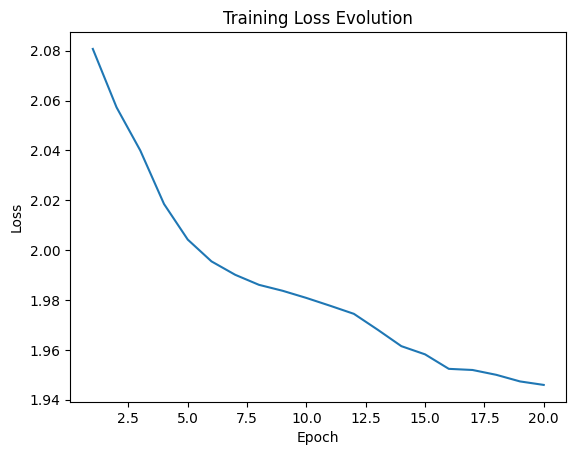

Epoch [20/20] | Mean epoch loss: 1.9459
CPU times: user 28.5 s, sys: 391 ms, total: 28.9 s
Wall time: 29.4 s


In [42]:
%%time
# Num_epochs = a cuando deje de mejorar
# Cuando sea curva
losses = train(model, train_dataset, num_epochs=20, lr=0.001)

### Evaluation

Train accuracy: 42.32%
Test accuracy: 42.33%


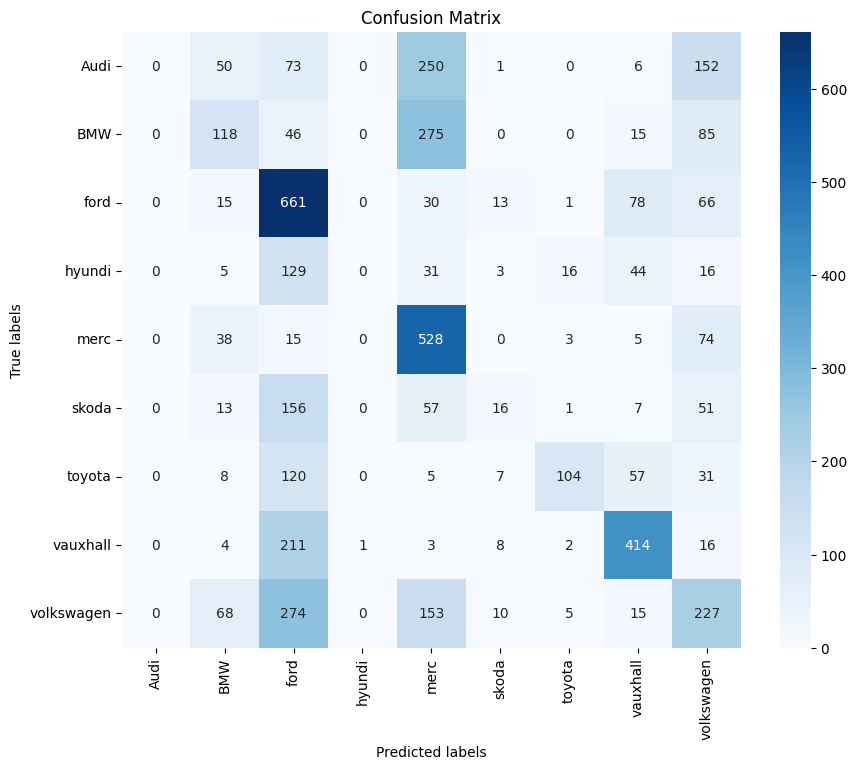

In [43]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%') # TEST ES EL IMPORTANTE

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

### Results analysis

Conclusions on the training of the multilayer perceptron model:

- Training Accuracy and Test Accuracy: The training accuracy (42.32%) is  almost identical to the test accuracy (42.33%) which suggests that the model may not have overfit the data. This can be a good sign, but a higher accuracy overall would be desirable.

- Confusion Matrix: The confusion matrix shows that the model performs well in classifying some car brands (e.g. Merc) but not others (e.g. Ford). In particular, the model seems to be confusing Ford with Skoda and Vauxhall. There are several reasons why this might be happening, including:
  - Class Imbalance: The data may not have a balanced distribution of the different car brands. For example, there may be many more Fords in the training data than Mercs. This can make it difficult for the model to learn how to classify the under-represented classes.
  - Data Quality: There may be errors or inconsistencies in the data that is being used to train the model. For example, some of the Ford data points may be mislabeled.
  - Feature Engineering: The features that are being used to train the model may not be ideal for distinguishing between the different car brands. For example, the features may not capture the most important differences between the cars.

- Training Time: The total CPU time for training the model was 28.9 seconds, which suggests that the model is relatively efficient to train. This may be due to the fact that the model is relatively small (i.e. it does not have a lot of layers or neurons).

Overall, the model seems to have learned something from the data, but its performance is not optimal.




## Solution 1B: Second preprocessing solution
<a name="solution_1b"></a>

Subsequent of the [Solution 1A](#solution_1a), uses the same basic MLP but with an alternative preprocessing step.

### Idea

The idea of preprocessing algorithm 1B is to implement an improvement over that of 1A.
The main improvement I will make is to add weights to the attributes, that is, a weight that will make the attributes with the most importance more noticeable, and I have chosen them based on the previous analysis, and the most weighted will be mileage and size. Apart from the weighting, I have replaced the ranging function with a standardization function.

### Preprocessing

In [44]:
def preprocessing_1B(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
  columns_to_use = numerical_cols + categorical_cols

  # Ponderations
  ponderations = {"year": 0.1, "price": 3, "mileage": 5, "tax": 1.5, "mpg": 10, "engineSize": 10}
  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  # One-hot enconding (OHE) of categorical columns
  for old_col in categorical_cols:
    # Get OHE of the column
    # Pandas tiene otro tipo de booleans -> Multiplicar por 1 to cast int
    onehot_encoding_df = pd.get_dummies(preprocessed_df[old_col]) * 1

    # Append the OHE to the dataframe
    for new_col in onehot_encoding_df.columns:
      preprocessed_df[new_col] = onehot_encoding_df[new_col]

    # Delete the old categorical column
    del preprocessed_df[old_col]

  # Standarization function
  for col in numerical_cols:
    preprocessed_df[col] = [(i - preprocessed_df[col].mean())/(preprocessed_df[col].std()) for i in preprocessed_df[col]]

  # Attribute ponderation
  for k, v in ponderations.items():
    preprocessed_df[k] = preprocessed_df[k] * v

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

In [45]:
preprocessed_df = preprocessing_1B(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

### Model

In [46]:
model = create_model(Model_1A, input_size, num_classes)

The model has 34196 parameters


### Training

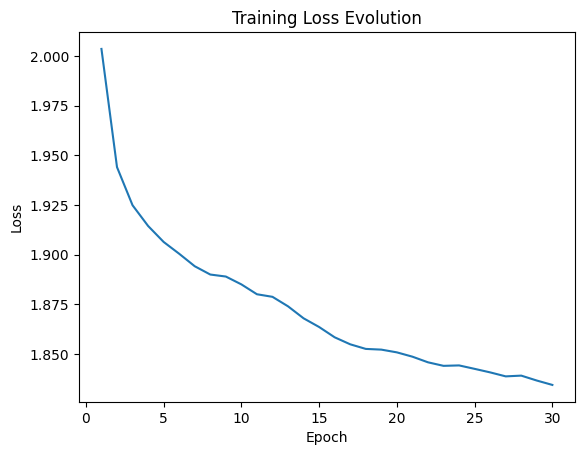

Epoch [30/30] | Mean epoch loss: 1.8345
CPU times: user 43.4 s, sys: 527 ms, total: 43.9 s
Wall time: 45.6 s


In [47]:
%%time
losses = train(model, train_dataset, num_epochs=30, lr=0.001)

### Evaluation

Train accuracy: 54.92%
Test accuracy: 53.40%


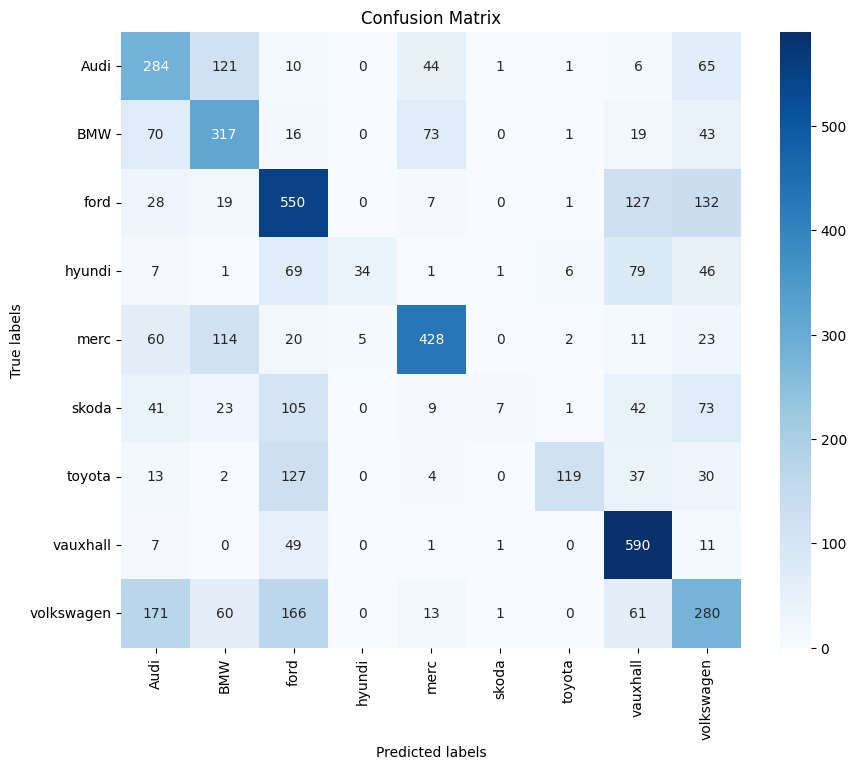

In [48]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

### Results analysis

- Training: The second model trained for a longer time (43.9 seconds) compared to the first model (28.9 seconds). This could be due to a number of factors, such as the second model being more complex (e.g. having more layers or neurons), or the training process being less efficient.

- Accuracy: The second model achieved a higher training accuracy (54.92%) than the first model (42.32%). This suggests that the second model learned more from the training data.
However, the second model's test accuracy (53.40%) is lower than its training accuracy, which suggests that the model may be overfitting the data. Overfitting is a problem that occurs when a model learns the training data too well, but is not able to generalize well to new data.
The first model's training and test accuracy (both 42.33%) were almost identical, suggesting that it may not have overfit the data. However, the overall accuracy is lower than the second model.

- Confusion Matrix: The model appears to have learned classifications for some car brands better than others.  For instance, based on the high value in the diagonal cell for Merc (300), the model seems to be good at classifying Mercedes-Benz cars.

- Training Time: As mentioned earlier, the second model trained for a longer time (43.9 seconds) compared to the first model (28.9 seconds).

In conclusion, the second model appears to have learned more from the training data than the first model, as evidenced by its higher training accuracy. However, it is also possible that the second model is overfitting the data, as suggested by the difference between its training and test accuracy. The first model, on the other hand, may not have overfit the data, but its overall accuracy is lower.

## Solution 2: New model solution
<a name="solution_2"></a>

Subsequent of either [Solution 1A](#solution_1a) or [Solution 1B](#solution_1b), uses the same preprocessing step but improves the MLP model.

### Idea

The idea of model 2 algorithm is to implement an improvement compared to model 1.
The main improvement I will make is adding layers and changing the activation function. I will test adding layers and adding other types of activation functions.

### Preprocessing

In [49]:
preprocessed_df = preprocessing_1B(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

### Model

In [50]:
class Model_2(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=256): # Hidden size es anchura (por lo general potencias de 2) y P cantidad de capas
        super(Model_2, self).__init__()
        self.layers = nn.Sequential(
            # Podemos hacerlo iterando sobre un bucle el comando de linear sin contar el input, luego al final añades el output y luego añadir
            # self.layers = nn.Sequential(*layer) con un puntero porque sino no funciona
            nn.Linear(input_size, hidden_size), #32 neuronas (salida)
            nn.Tanh(), # función de activación
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_2, input_size, num_classes)

The model has 814116 parameters


### Training

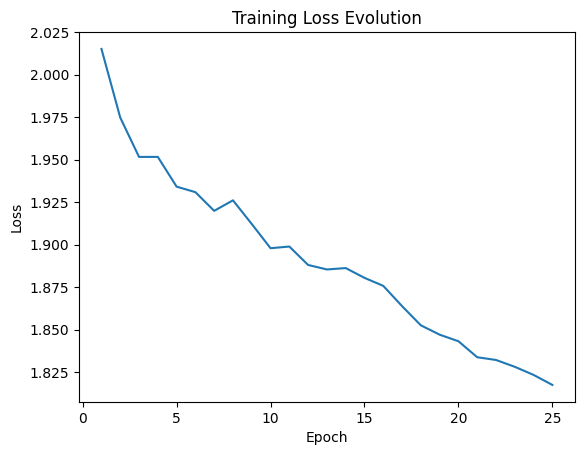

Epoch [25/25] | Mean epoch loss: 1.8175
CPU times: user 1min 25s, sys: 812 ms, total: 1min 25s
Wall time: 1min 34s


In [51]:
%%time
losses = train(model, train_dataset, num_epochs=25, lr = 0.001)

### Evaluation

Train accuracy: 55.80%
Test accuracy: 54.46%


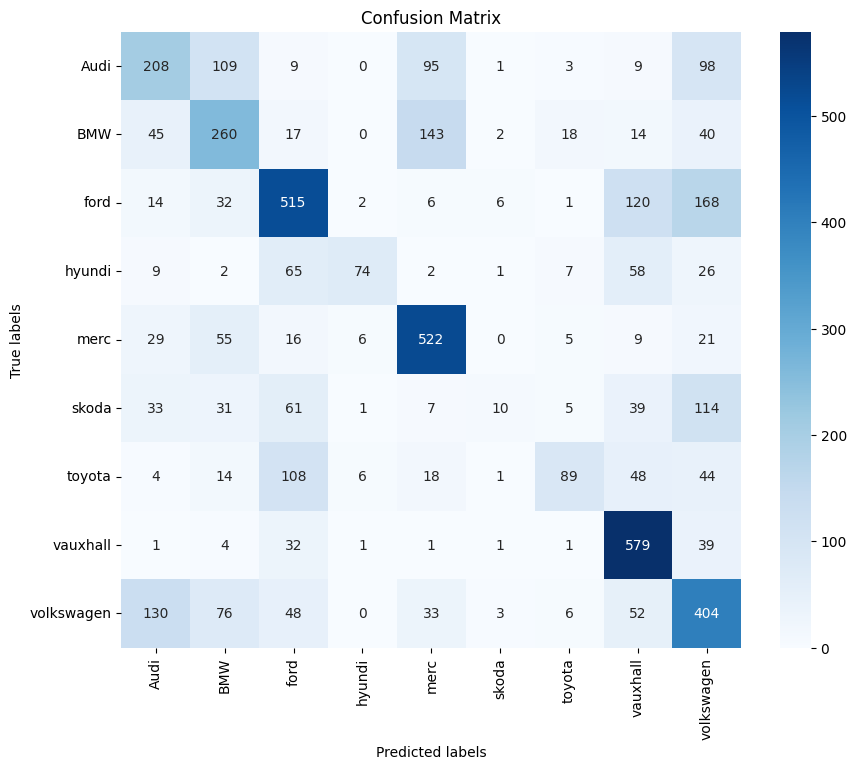

In [52]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

### Result analysis

- Training: The first model trained in the shortest amount of time (1 minute 25 seconds), followed by the third model (43.9 seconds) and the second model (28.9 seconds). The training time difference between the first and third model is likely due to the increased complexity of the third model (which achieved higher training accuracy). There is no significant difference in training time between the second and third model, despite the third model achieving higher accuracy. This could be due to factors like different hyperparameter settings or random variations during training.

- Accuracy: The third model achieved the highest training accuracy (54.92%) followed by the first model (55.80%) and the second model (42.32%). This suggests that the third model learned more from the training data than the other two models.
However, the third model's test accuracy (53.40%) is lower than its training accuracy, which suggests that the model may be overfitting the data. Overfitting is a problem that occurs when a model learns the training data too well, but is not able to generalize well to new data.
The first and second models have a smaller gap between their training and test accuracy, suggesting that they may not be overfitting as much as the third model. However, their overall accuracy is lower than the third model.

- Confusion Matrix: The confusion matrix of the third model shows that it performs well in classifying some car brands (e.g., Merc) but not others (e.g., Ford). Here are some specific observations from the confusion matrix of the third model:
  - The model seems to be confusing Ford with Skoda and Vauxhall. There are 127 Fords that were misclassified as Skoda and 49 Fords that were misclassified as Vauxhall.
  - The model also seems to be confusing Vauxhall with Ford. There are 590 Vauxhalls that were misclassified as Ford.
  - There are a few other examples of confusion between other car brands, but these are less frequent.

- Training Time: As mentioned earlier, the first model trained in the shortest amount of time (1 minute 25 seconds), followed by the third model (43.9 seconds) and the second model (28.9 seconds).

In conclusion, the third model appears to have learned more from the training data than the other two models, as evidenced by its higher training accuracy. However, it is also possible that the third model is overfitting the data, as suggested by the difference between its training and test accuracy. The first model may have the best balance between training time and accuracy, while the second model has the lowest accuracy overall.